In [28]:
import h5py
from pyrsimg import readTiff, imgShow, geo2imagexy
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import Point



In [8]:
path_glah14 = 'data/laser/isat_gla_region.h5'
path_rsimg = 'data/rsimg/s2_gla_region_20220707.tif'
path_dem = 'data/srtm/SRTMGL1Ellip_gla_region.tif'
path_gla_vec = 'data/laser/gla_region.gpkg'

In [ ]:
!h5ls $path_glah14


att_flg                  Dataset {215}
delta_ellip              Dataset {215}
elev                     Dataset {215}
elev_cor                 Dataset {215}
elev_flg                 Dataset {215}
lat                      Dataset {215}
lon                      Dataset {215}
satu_cor                 Dataset {215}
satu_flg                 Dataset {215}
time                     Dataset {215}
time_dyr                 Dataset {215}


In [ ]:
vars_glah14 = {}
with h5py.File(path_glah14, 'r') as glah14:
    vars_glah14['lat'] = glah14['lat'][:]
    vars_glah14['lon'] = glah14['lon'][:]
    vars_glah14['time_dyr'] = glah14['time_dyr'][:]
    vars_glah14['elev_cor'] = glah14['elev_cor'][:]

vars_glah14['lat'].shape

rsimg = readTiff(path_rsimg)
dem = readTiff(path_dem)
gla_vec = gpd.read_file(path_gla_vec)



<Axes: >

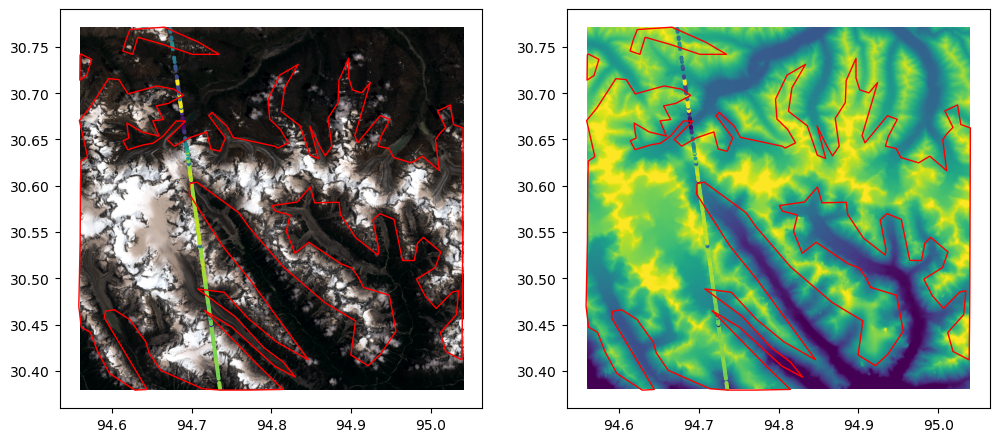

In [16]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
imgShow(rsimg.array, extent=rsimg.geoextent, per_band_clip=10, ax=ax[0])
ax[0].scatter(x=vars_glah14['lon'], y=vars_glah14['lat'], c=vars_glah14['elev_cor'], s=3.5)
gla_vec.plot(ax=ax[0], facecolor='none', edgecolor='red')

imgShow(dem.array, extent=dem.geoextent, per_band_clip=10, ax=ax[1])
ax[1].scatter(x=vars_glah14['lon'], y=vars_glah14['lat'], c=vars_glah14['elev_cor'], s=3.5)
gla_vec.plot(ax=ax[1], facecolor='none', edgecolor='red')



In [ ]:
import numpy as np
### 数据筛选：冰川区域；非冰川区域
ids_gla = np.zeros(shape=vars_glah14['lon'].shape) 
for i, lon in enumerate(vars_glah14['lon']):
    point = Point(lon, vars_glah14['lat'][i])
    if gla_vec.geometry[0].contains(point):
        ids_gla[i] = 1

ids_gla


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.])

In [35]:
row, col = geo2imagexy(x=vars_glah14['lon'], y= vars_glah14['lat'], 
                       gdal_trans=dem.geotrans, rsimg_array=dem.array, integer=True)

dem_isat_fp = dem.array[row, col]
dem_isat_fp[10:20]


array([4397.7890625 , 4476.79150391, 4603.79443359, 4726.796875  ,
       4810.79980469, 4844.80224609, 4858.8046875 , 4918.80712891,
       4967.80957031, 5044.8125    ])

Text(0.5, 1.0, 'non-glacier region')

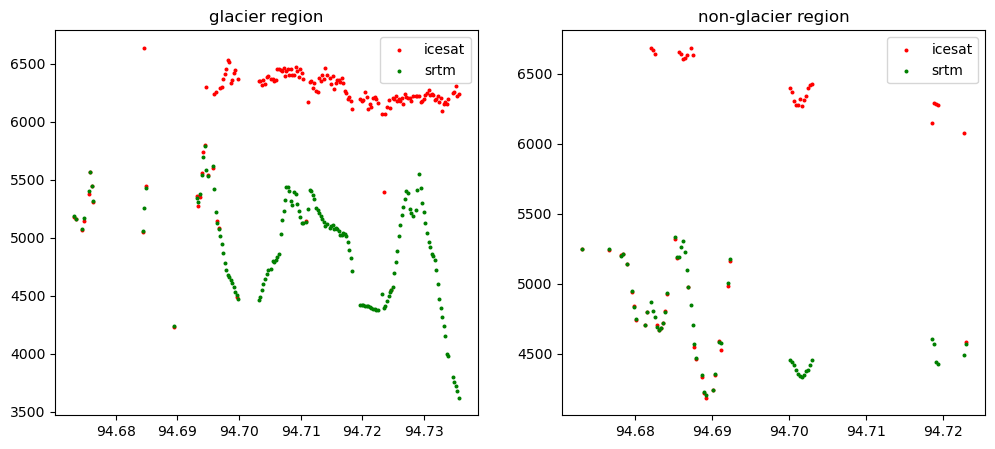

In [42]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
ax[0].scatter(x=vars_glah14['lon'][ids_gla==1], y=vars_glah14['elev_cor'][ids_gla==1], c='red', s=3.5,label='icesat')
ax[0].scatter(x=vars_glah14['lon'][ids_gla==1], y=dem_isat_fp[ids_gla==1], c='green', s=3.5, label='srtm')
ax[0].legend()
ax[0].set_title('glacier region')

ax[1].scatter(x=vars_glah14['lon'][ids_gla==0], y=vars_glah14['elev_cor'][ids_gla==0], c='red', s=3.5,label='icesat')
ax[1].scatter(x=vars_glah14['lon'][ids_gla==0], y=dem_isat_fp[ids_gla==0], c='green', s=3.5, label='srtm')
ax[1].legend()
ax[1].set_title('non-glacier region')



In [47]:
dif_ele = vars_glah14['elev_cor'] - dem_isat_fp
## glacier 
ids_ele_thre = np.where((ids_gla==1) & (abs(dif_ele)<150))
dif_ele_gla = dif_ele[ids_ele_thre]
print(dif_ele_gla.mean())

## non-glacier 
ids_ele_thre = np.where((ids_gla==0) & (abs(dif_ele)<150))
dif_ele_stable = dif_ele[ids_ele_thre]
print(dif_ele_stable.mean())


-2.111753417968354
-4.229154485886694


In [ ]:
dif_ele_gla_cor = dif_ele_gla.mean()-dif_ele_stable.mean()
print(dif_ele_gla_cor)


2.11740106791834


In [51]:
gla_ele_change_rate = dif_ele_gla_cor/(vars_glah14['time_dyr'][0] - 2000)
print(gla_ele_change_rate)


0.4379474065217575


In [52]:
sigma = np.std(dif_ele_stable)
print(sigma)


11.813995827564204
